### Now we continue talk about neural network and in this notebook we'll know how, using dataset we can do:
* Some augmentation.
* Early stopping
* Decaying learning rate

In this case we use batch class and model from task_02.

In [1]:
import os
import sys

import blosc
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook as tqn
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append('..')

import utils
from task_02.my_batch import MnistBatch
from task_02.simple_conv_model import ConvModel

from dataset import Dataset, DatasetIndex, B,V,F
from dataset.dataset.opensets import MNIST

As in previous times, we create dataset with our batch class and train model after it.

In [2]:
ix = DatasetIndex(range(65000))
mnist = Dataset(ix, batch_class=MnistBatch)
mnist.cv_split([0.8, 0.1, 0.1])

In [3]:
src = '../MNIST_data/'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())

In [4]:
src = (full_imgs, full_labs)

It is worth paying attention to the fact that random_rotate and random_scale is elements of ImagesBatch class - it is parent our class. You can see all writing augmentations [here](https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py).

In [5]:
train_pipeline = (mnist.train
                .p
                .load(src)
                .shift_flattened_pic()
                .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                .init_variable('train_accuracy', init_on_each_run=list)
                .init_model('dynamic',
                         ConvModel,
                         'conv',
                         config={'loss': 'softmax_cross_entropy',
                                'decay': ('exp', {'learning_rate': 0.001,
                                                'decay_steps': 150,
                                                'decay_rate': 0.96}),
                                'optimizer':'RMSProp'})
                .train_model('conv',
                             fetches='accuracy',
                             feed_dict={'input': B('images'),
                                    'targets': B('labels'),
                                    'dropout_rate': 0.4},
                              append_to=V('train_accuracy')))

In [6]:
test_pipeline = (mnist.test
                 .p
                 .load(src)
                 .import_model('conv', train_pipeline)
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                 .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                 .init_variable('test_accuracy', init_on_each_run=list)
                 .predict_model('conv', 
                             fetches='accuracy',
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.4},
                             append_to=V('test_accuracy')))

We introduce early stopping, if average accuracy for 'window' epochs will be more than 0.99.

In [7]:
MAX_ITER = 500
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)
    
    #Early stopping
    if curr_iter % window == 0:
        average.append(np.mean(test_pipeline.get_variable('test_accuracy')[curr_iter - window:]))
        
    if average[-1] > 0.95:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we predict image class on validation data.

../utils.py:48: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:49: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


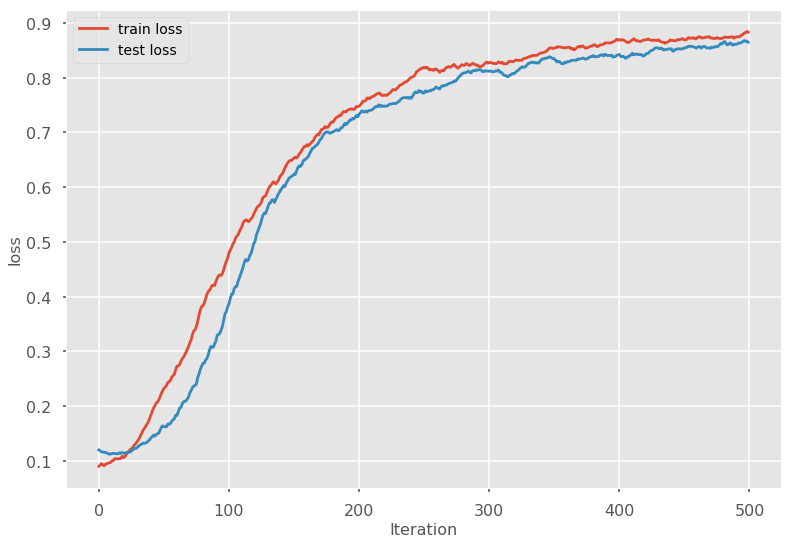

In [8]:
train_accuracy = train_pipeline.get_variable('train_accuracy')
test_accuracy = test_pipeline.get_variable('test_accuracy')
utils.draw(train_accuracy,'train', test_accuracy, 'test', 'loss')

In [11]:
validation_pipeline = (mnist.test
                .p
                .import_model('conv', train_pipeline)
                .load(src)
                .shift_flattened_pic()
                .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                .init_variable('answer', init_on_each_run=list)
                .init_variable('img', init_on_each_run=list)
                .init_variable('predict', init_on_each_run=list)
                .init_variable('prob', init_on_each_run=list)
                .predict_model('conv', 
                             fetches=['targets', 'input', 'labels_hat', 'prob_predictions'],
                             feed_dict={'input': B('images'),
                                        'targets': B('labels'),
                                        'dropout_rate': 0.4},
                             append_to=[V('answer'), V('img'), V('predict'), V('prob')]))

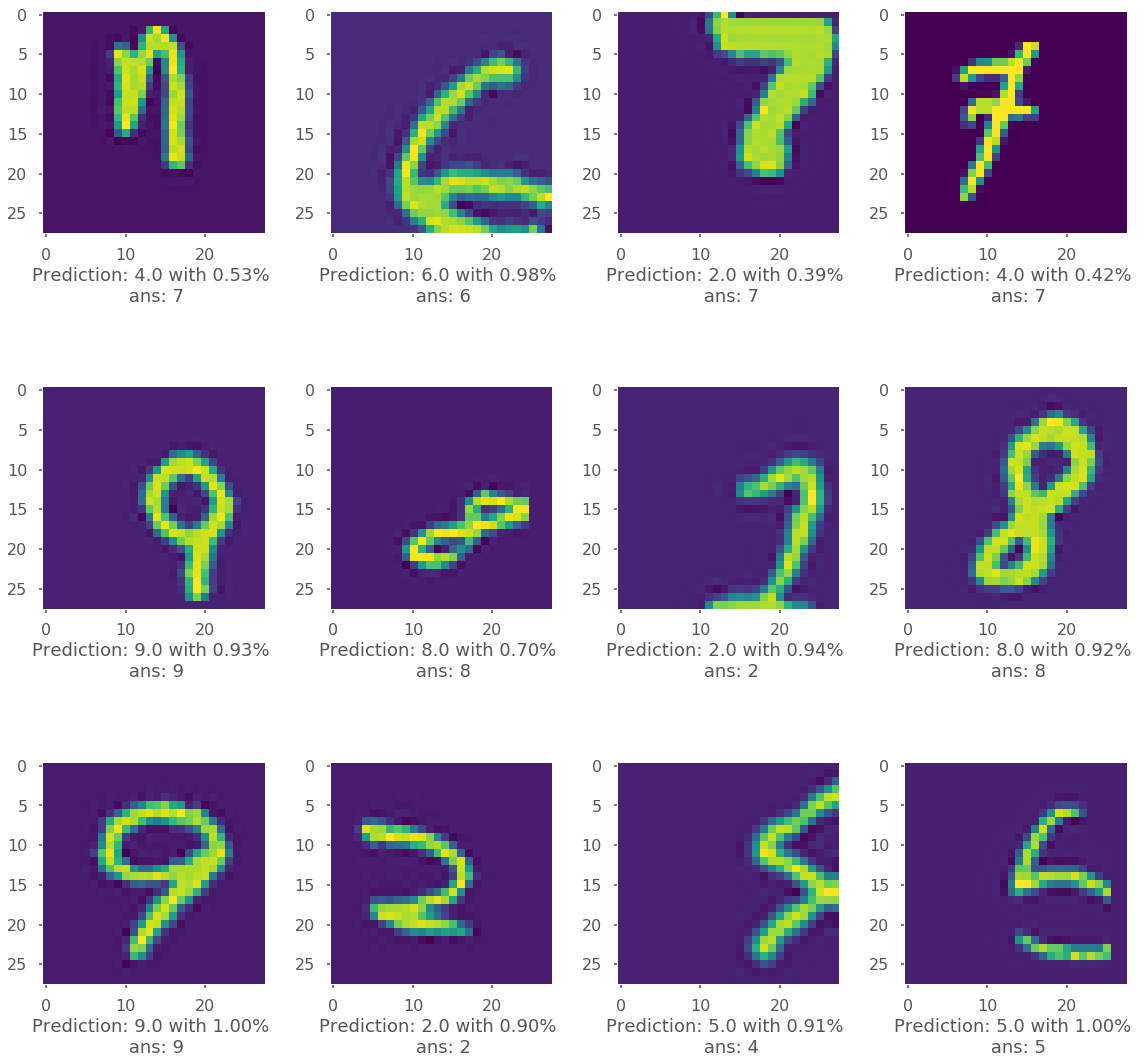

In [13]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)

for num_batch in range(12):
    validation_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    
    answer= validation_pipeline.get_variable('answer')
    img = validation_pipeline.get_variable('img')
    predict = validation_pipeline.get_variable('predict')
    prob = validation_pipeline.get_variable('prob')

    ax[num_batch].imshow(img[-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}% \n ans: {}'.format(predict[-1][0],
                                                            prob[-1][0] \
                                                            [np.argmax(prob[-1])], \
                                                            np.argmax(answer[-1])), fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Not difficult to see, that network can teach rotate and scale changes.